In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from beamline34IDC.simulation.facade import Implementors
from beamline34IDC.simulation.facade.focusing_optics_factory import focusing_optics_factory_method
from beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
from beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
#from beamline34IDC.util.redirect_shadow_output import redirected_output

In [3]:
%matplotlib inline

In [4]:
DEFAULT_RANDOM_SEED = 111

In [18]:
work_dir = '/Users/saugat/code/oasys/ML_Control_System/work_directory'
os.chdir(work_dir)
input_beam_path = "primary_optics_system_beam.dat"
#input_beam = load_shadow_beam()

In [7]:
fig_save_path = 'figures/opt_hkb_mot4_only/'

In [59]:
move_motors = ['vkb_4']

In [8]:
# Focusing Optics System -------------------------
focusing_system, out_beam = opt_common.reinitialize(input_beam_path=input_beam_path)

trans 0.0 current loss 7.625219885299723e-05
7.625219885299723e-05 7.625219885299723e-05


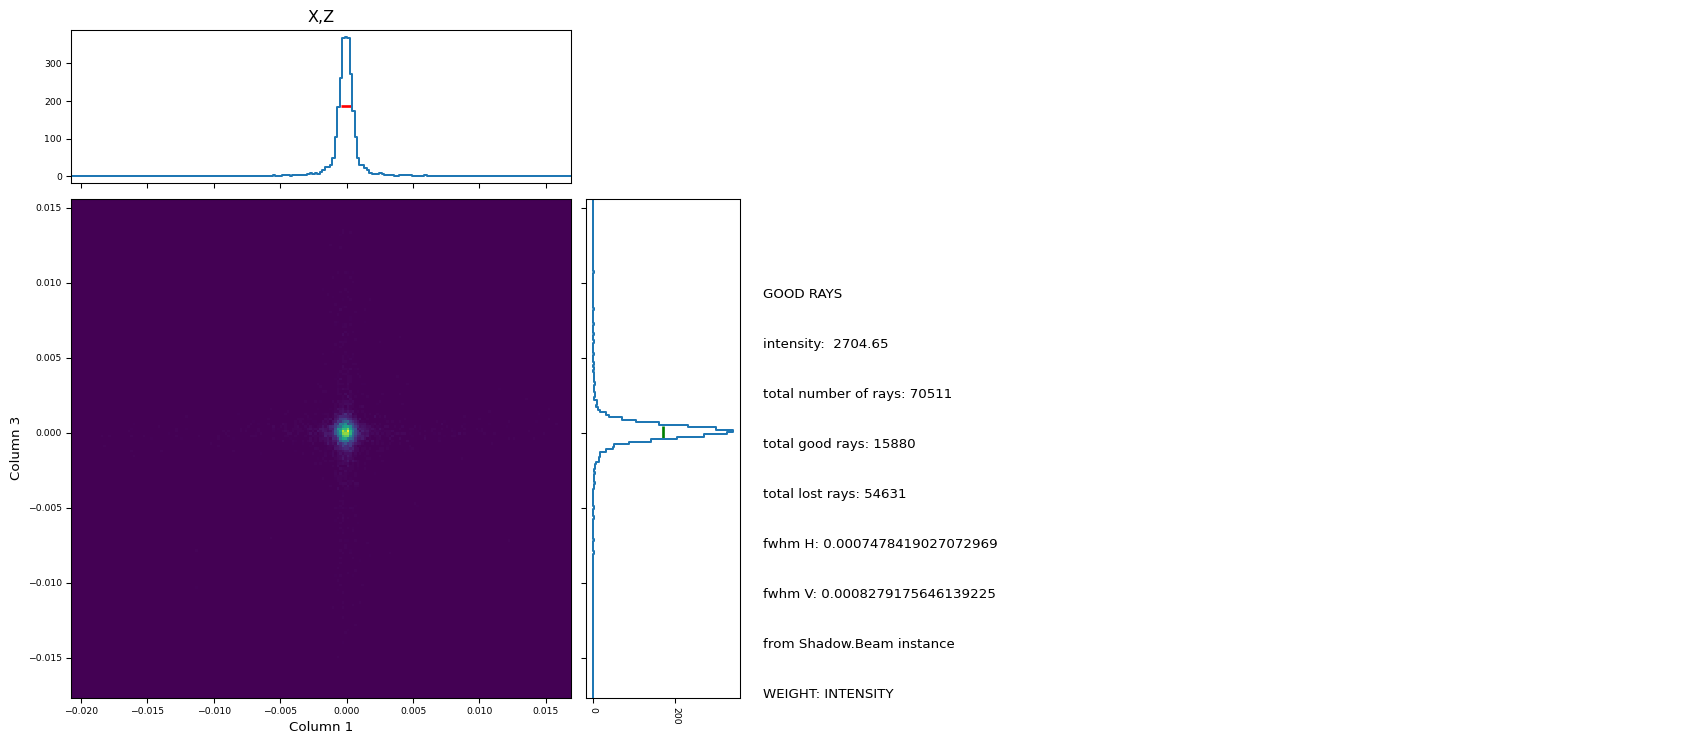

In [9]:
centroid, out_beam, hist, dw = opt_common.getCentroidDistance(focusing_system)
print(centroid, opt_common.lossFunction(focusing_system, move_motors, 0.))
_ = plot_shadow_beam_spatial_distribution(out_beam)

In [17]:
initial_centroids = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_centroids = []
final_out_beams = []

for outer in tqdm(range(10)):
    translations = np.random.uniform(-0.14, 0.14)
    focusing_system = opt_common.moveMotors(focusing_system, move_motors, translations, movement='absolute')
    centroid, out_beam, *_ = opt_common.getCentroidDistance(focusing_system)
    absolute_movements.append(translations)
    initial_centroids.append(centroid)
    initial_out_beams.append(out_beam)
    focusing_system, guesses_all, success = opt_common.optimizationTrials(focusing_system, move_motors, translations, 
                                                               DEFAULT_RANDOM_SEED, 5, verbose=True)
    start_guesses.append(guesses_all)
    overall_successes.append(success)
    centroid, out_beam, *_ = opt_common.getCentroidDistance(focusing_system)
    final_centroids.append(centroid)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')
    

  0%|          | 0/10 [00:00<?, ?it/s]

trans [-0.00340943] current loss 0.07910367414325863
trans [-0.00017047] current loss 0.07927315116050136
trans [0.00034094] current loss 0.07893316660307498
trans [0.00034094] current loss 0.07859320515053682
trans [0.00051141] current loss 0.07808364662889063
trans [0.00102283] current loss 0.07706531055649586
trans [0.00153424] current loss 0.07553614273230264
trans [0.00306848] current loss 0.07247857197670318
trans [0.00460273] current loss 0.06789297604963347
trans [0.00920545] current loss 0.05872156974405495
trans [0.01380818] current loss 0.044965640901005355
trans [0.02761635] current loss 0.01757031797204106
trans [0.04142453] current loss 0.023864653861310325
trans [-0.0310684] current loss 0.0071231152784449105
trans [0.01035613] current loss 0.00335019097929285
trans [0.02071227] current loss 0.023864653861310394
trans [-0.01035613] current loss 0.01378970975355541
trans [-0.01294517] current loss 0.0007363719053587479
trans [-0.00258903] current loss 0.001886374883491347

In [50]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [31]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [52]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [45]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

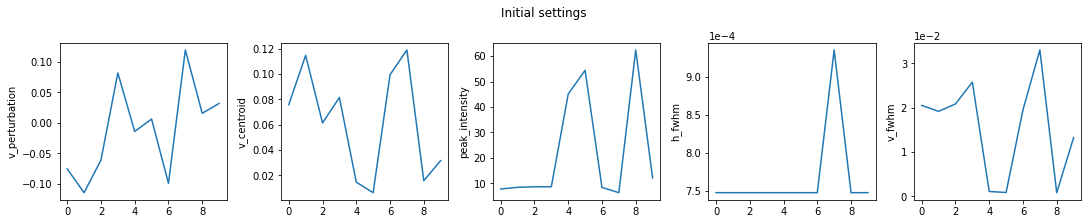

In [47]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('v_perturbation')

axes[1].plot(initial_centroids)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/vkb_4_initial_metrics.png', bbox_inches='tight')

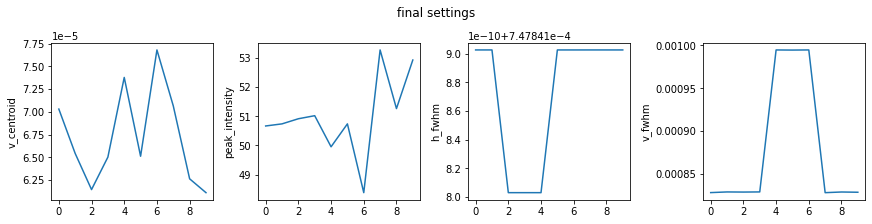

In [49]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_centroids)
axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/vkb_4_final_metrics.png', bbox_inches='tight')

/Applications/Oasys1.2.app/Contents/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


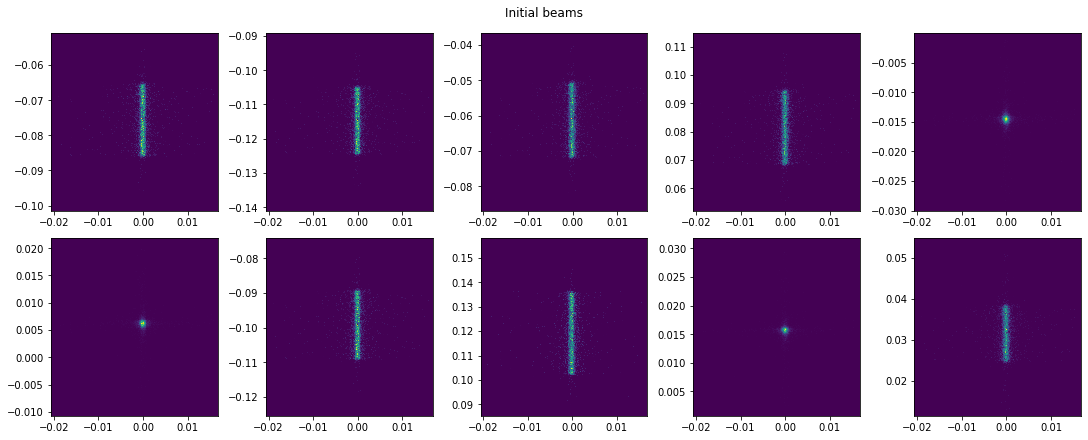

In [56]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D.T)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/vkb_4_initial_beams.png', bbox_inches='tight')

/Applications/Oasys1.2.app/Contents/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


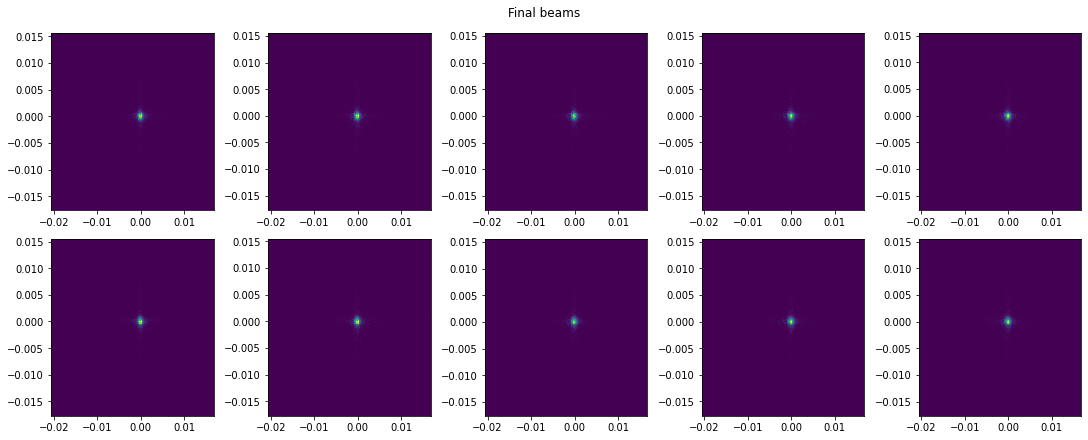

In [57]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D.T)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/vkb_4_final_beams.png', bbox_inches='tight')

In [2]:
clean_up()

NameError: name 'clean_up' is not defined